In [19]:
import numpy as np
import matplotlib.pyplot as plt
import argparse as ap
import csv
import torch.nn.functional as F
import torch.nn as nn
import torch
import glob
import os
import pandas as pd
import random
import math
from tqdm import tqdm

In [11]:
# Args
# tmd = tech, media and telecom
# hc = healthcare
# cr = consumer and retail
# fig = finnancial institution groups
# ind = industrials
# pnr = power and natural resources


class args:
    sector = "tmd"
    model_save = 'output.txt'
    batch_size = 10
    train_steps = 500
    learning_rate = 0.001
    classes = 100
    cnn_n1_channels = 10 # I hope this works: 05/04/2020
    cnn_n1_kernel = 3
    cnn_n2_kernel = 3
    cnn_n3_kernel = 3
    model = 'simple-cnn'
    log_file = 'logfile.txt'

In [3]:
# Data Reading from raw files

# retval = os.getcwd()
# print(retval)
def loadData():
    path = "/mnt/c/Minted/Data"

    path, dirs, files = next(os.walk(path))
    num_stocks = len(files) - 1
    
    print(num_stocks)
    
    prices = np.zeros((num_stocks, 124))
    price_index = 4 # highs
    iterations = 0
    preds = np.zeros(num_stocks)
    
    os.chdir(path)
    for file in glob.glob("*.csv"): 
        
        # print("entered")
        
        i = 125
        this_prices = np.zeros(124)
        with open(file) as csvfile:
            readCSV = csv.reader(csvfile, delimiter=',')
            for row in readCSV:
                ind = (row[price_index].find('$')) + 1
                if i == 125:
                    i -= 1
                    continue
                if i == 124:
                    preds[iterations] = float(row[price_index][ind:])
                    i -= 1
                    continue
                prices[iterations][i] = float(row[price_index][ind:])
                
                # print(float(row[price_index][ind:]))
                # print(prices[iterations][i])

                i -= 1

        iterations += 1
    
    for i in range(num_stocks):
        maximum = 0
        max_prices = max(prices[i])
        if preds[i] > max_prices:
            maximum = preds[i]
        else:
            maximum = max_prices
    
        prices[i] /= maximum
        preds[i] /= maximum
    
    # print(prices.shape)
    # print(prices)

    plt.figure()
    plt.plot(prices[0])
    plt.title("AAOI")
    
    # print(prices[0])
    # print(len(prices[0]))
    # print(preds[0])
    
    train_data = []
    train_labels = []
    dev_data = []
    dev_labels = []   
    
    train_percent = 0.8
    # train_num = math.ceil(0.8 * num_stocks)
    train_num = math.floor(0.8 * num_stocks)
    res = random.sample(range(0, num_stocks), train_num)

    for i in range(num_stocks):
        if i in res:
            train_data.append(prices[i])
            train_labels.append(preds[i])
        else:
            dev_data.append(prices[i])
            dev_labels.append(preds[i])
    
    return train_data, train_labels, dev_data, dev_labels



# prices = np.transpose(prices)


In [4]:
# Data Pre-Processing
    # Averaging, getting rid of noise, etc.
    # normalization?
# def splitData():
    

31
24


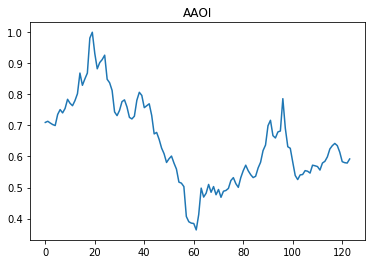

In [5]:
loaded = False

if not loaded:
    train_data, train_labels, dev_data, dev_labels = loadData()
    print(len(train_data))
    # splitData()
    os.chdir("/mnt/c/Minted")
    np.save("training_data.npy", train_data)
    np.save("training_labels.npy", train_labels)
    np.save("development_data.npy", dev_data)
    np.save("development_labels.npy", dev_labels)

In [6]:
train_data = np.load("training_data.npy")
train_labels = np.load("training_labels.npy")
dev_data = np.load("development_data.npy")
dev_labels = np.load("development_labels.npy")

In [7]:
# train_data = torch.Tensor([i for i in train_data])
# # train_data = train_X / 4095.0
# train_labels = torch.Tensor([i for i in train_labels])

# test_data = torch.Tensor([i for i in dev_data])
# # test_X = test_X / 4095.0
# test_labels = torch.Tensor([i for i in dev_labels])

# train_labels = train_labels.long()
# test_labels = test_labels.long()

In [8]:
class SimpleCNN(torch.nn.Module):
    def __init__(self, n1_kern, n2_kern, n3_kern, n1_chan):
        super(SimpleCNN, self).__init__()
        # kernel = (n1_kern, n2_kern, n3_kern)
        self.conv1 = torch.nn.Conv2d(1, n1_chan, kernel_size=n1_kern)
        self.conv2 = torch.nn.Conv2d(n1_chan, 2, kernel_size=n2_kern, stride=2)

    def forward(self, x):
        size = x.size()[0]
        x = x.view(size, 1, 512, 512)
        Relu1 = F.relu(self.conv1(x))
        Relu2 = F.relu(Relu1)
        dim3 = Relu2.size()[2]
        dim4 = Relu2.size()[3]
        pool = nn.MaxPool2d((dim3, dim4), stride=2)
        logits = pool(Relu2)
        logits = logits.view(logits.size()[0], 40)
        return logits

In [9]:
# Train and predict with neural net
net = SimpleCNN(args.cnn_n1_kernel, args.cnn_n2_kernel, args.cnn_n1_channels, args.classes)

# Define the optimizer & loss function
import torch.optim as optim
optimizer = optim.Adam(net.parameters(), lr = 0.001)
loss_function = nn.CrossEntropyLoss() # Different Format of y shape
def fwd_pass(X, y, train = False, calc_acc = False):
    if train:
        net.zero_grad()
    outputs = net(X)
    
#     if calc_acc:
#         total_matches = 0
#         for i in tqdm(range(outputs.shape[0])):
#             for j in range(outputs.shape[2]):
#                 matches = [torch.argmax(outputs[i,:,j,k]) == y[i,j,k] for k in range(outputs.shape[3])]
#                 total_matches += matches.count(True)

#         acc = total_matches / (outputs.shape[0]*outputs.shape[2]*outputs.shape[3])
#     else:
#         acc = 0
    
    loss = loss_function(outputs,y)
    
    if train:
        loss.backward()
        optimizer.step()
        
    return acc, loss

In [10]:
def test(size = 32, calc_acc = False):
    random_start = np.random.randint(len(test_X) - size)
    X,y = dev_data[random_start:random_start+size], dev_labels[random_start:random_start+size]
    with torch.no_grad():
        val_acc, val_loss = fwd_pass(X,y, calc_acc = calc_acc)
    return val_acc, val_loss

In [20]:
import time

MODEL_NAME = f"model-{int(time.time())}"

net = SimpleCNN(args.cnn_n1_kernel, args.cnn_n2_kernel, args.cnn_n3_kernel, args.cnn_n1_channels)
optimizer = optim.Adam(net.parameters(), lr = args.learning_rate)
loss_function = nn.CrossEntropyLoss()

print(MODEL_NAME)

def train():
    BATCH_SIZE = 100 # 55 to 100 is fine
    EPOCHS = 250 # 250 is fine right now
    with open("model.log", "w") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0,len(train_data), BATCH_SIZE)):
                batch_X = train_data[i:i+BATCH_SIZE]
                batch_y = train_labels[i:i+BATCH_SIZE]
                
                acc, loss = fwd_pass(batch_X, batch_y, train = True)
                if i % 50 == 0:
                    val_acc, val_loss = test(size = 100)
                    f.write(f"{MODEL_NAME},{round(time.time(),3)}, {round(float(acc),2)}, {round(float(loss),4)}, {round(float(val_acc),2)}, {round(float(val_loss),4)} \n")

train()

  0%|          | 0/1 [00:00<?, ?it/s]

model-1592633746


TypeError: 'int' object is not callable

In [ ]:
# Data Post Processing

In [ ]:
# Create pattern model to use in tandem with this (probably separate notebook)
# Final predictions